In [1]:
import pandas as pd
from analysis_pkg.tools.image_coord_locater import open_video
import json
import numpy as np
import matplotlib.pyplot as plt
import cv2
import xarray as xr
import os
import scipy
import pickle as pkl
from bisect import bisect_left
from analysis_pkg.analysis.ranking import rank_by_total_wins

In [27]:
def load_bpod_data(dpath):
    with open(dpath, 'r') as file:
        data = json.load(file)
    return data

def take_closest(array1, array2):
    """
    Assumes array1 is sorted. Returns closest stamps to the given array2.

    If two numbers are equally close, return the smallest number.
    """
    msAlignedIndex = []
    for bpod_stamp in array2:
        pos = bisect_left(array1, bpod_stamp)
        if pos == 0:
            return array1[0]
        if pos == len(array1):
            return array1[-1]
        before = array1[pos - 1]
        after = array1[pos]
        if after - bpod_stamp < bpod_stamp - before:
            msAlignedIndex.append(np.where(array1 ==after))
        else:
            msAlignedIndex.append(np.where(array1 ==before))
    return np.squeeze(np.array(msAlignedIndex))
    
def get_state_time(state, bpod_data, trialnumbers=None):
    """
    Input a state name and bpod_data. Return the time stamp of the state(relative to trial start)
    """
    onsets = []

    if trialnumbers is not None:
        for trialnumber in trialnumbers:
            trial = bpod_data["SessionData"]['RawEvents']['Trial'][trialnumber]
            if type(trial['States'][state]) != float:
                onsets.append(trial['States'][state][0])
            else:
                onsets.append(trial['States'][state])
    else:
        for trial in bpod_data["SessionData"]['RawEvents']['Trial']:
            if type(trial['States'][state][0]) != float:
                onsets.append(np.squeeze(trial['States'][state][0]))
            else:
                onsets.append(np.squeeze(trial['States'][state])[0])
    return np.array(onsets)
    
def get_event_time(event, bpod_data, trialnumbers=None):
    """
    Input a event name and bpod_data. Return the time stamp of the event(relative to trial start)
    """
    onsets = []

    ### Get the events' onsets for the indicated trials
    if trialnumbers is not None:
        for trialnumber in trialnumbers:
            trial = bpod_data["SessionData"]['RawEvents']['Trial'][trialnumber]
            if type(trial['Events'][event]) != float:
                onsets.append(trial['Events'][event][0])
            else:
                onsets.append(trial['Events'][event])

    ### Get the events' onsets for all trials
    else:
        for trial in bpod_data["SessionData"]['RawEvents']['Trial']:
            if not trial['event']['WrongPort'][0]:
                if type(trial['States'][event][0]) != float:
                    onsets.append(np.squeeze(trial['Events'][event][0])[0])
                else:
                    onsets.append(np.squeeze(trial['Events'][event])[0])
    return np.array(onsets)

def get_RPE_neuron_activities(trialRewards, calcium_activities, calcium_baselines):
    """Select RPE relative neurons using the method from Muller. 2024 """
    RPE_neurons = []
    RPE_neurons_id = []
    for i, singleNeuronActivity in enumerate(calcium_activities):
        model = sm.OLS(singleNeuronActivity, trialRewards).fit()
        if model.pvalues < 0.005:
            # print(singleNeuronActivity)
            # print(calcium_baselines[i])
            # print(singleNeuronActivity-calcium_baselines[i])
            RPE_neurons.append(singleNeuronActivity-calcium_baselines[i])
            RPE_neurons_id.append(i)
    return np.array(RPE_neurons), np.array(RPE_neurons_id)

def mean_across_events(events, raw_neural_activities, fps=30, duration=2):  
    sum_acitivities = np.zeros((raw_neural_activities.shape[0],duration*2*fps))
    for event in events:
        raw_neural_activities_cue_onset = np.array(raw_neural_activities[:, event-duration*fps:event+duration*fps])
        sum_acitivities = raw_neural_activities_cue_onset + sum_acitivities
    return sum_acitivities/len(events)

def z_score(data, axis=1):
    return (data-data.mean(axis=1, keepdims=True))/data.std(axis=1, keepdims=True)

In [3]:
# open_video('/Users/fgs/HMLworkplace/Arena_analysis/Data/behavior_videos/ZZ0024-L_ZZ0024-LR_20240926-111343_highsat.mp4')

In [4]:
plate_center = [1047,1059]
plate_radius = 185

In [5]:
mouse = 'ZZ0024-L' 
mouse_pair = 'ZZ0024-L_ZZ0024-LR'
date = '20240925'

In [6]:
ms_stamps = np.squeeze(scipy.io.loadmat(f"/Users/fgs/HMLworkplace/Arena_analysis/Data/ws_data/processed/{mouse}/{mouse}_{date}_ms.mat")['ms_frames_samplingstamps'])
bpod_trialstart_stamps = np.squeeze(scipy.io.loadmat(f"/Users/fgs/HMLworkplace/Arena_analysis/Data/ws_data/processed/{mouse}/{mouse}_{date}_bpod.mat")['bpod_trialstart_samplingstamps'])

bpod_data = load_bpod_data(f'/Users/fgs/HMLworkplace/Arena_analysis/Data/bpod_data/{mouse_pair}/{mouse_pair}_{date}.json')

minian_results = xr.open_dataset(f"/Users/fgs/HMLworkplace/Arena_analysis/Data/minian_data/{mouse}_{date}.netcdf")
calcium_traces = minian_results.C
calcium_traces = calcium_traces.T

with open(f'/Users/fgs/HMLworkplace/Arena_analysis/Data/bahavior_led_frames/{mouse_pair}_{date}.pickle', 'rb') as f:
    dlc_trialStartStamps = np.array(pkl.load(f))

In [19]:
trialTypes = np.array(bpod_data['SessionData']['TrialTypes'])
onePortTrials = np.where(trialTypes==1)[0]
wins_per_trial, _ = rank_by_total_wins(f'/Volumes/Hiroshi Makino/User/KinOn/Data/diversity_training/processed/{mouse_pair}/multiple_mice_competition/{date}/', bodypart='body_middle')
ind1_winTrials = []
ind2_winTrials = []
for onePortTrial in onePortTrials:
    if wins_per_trial[onePortTrial]['individual1'] == 1:
        ind1_winTrials.append(onePortTrial)
    if wins_per_trial[onePortTrial]['individual2'] == 1:
        ind2_winTrials.append(onePortTrial)
ind1_winTrials = np.array(ind1_winTrials)
ind2_winTrials = np.array(ind2_winTrials)

Overall Tally: {'individual2': 15, 'individual1': 7}
Trial Type Tally: {1: {'individual2': 15, 'individual1': 7}, 2: {'individual2': 0, 'individual1': 0}}


In [29]:
toneTimes = get_state_time('Tone', bpod_data)
toneFrames = np.rint(30*toneTimes).astype(int)
ms_trialStartStamps = take_closest(ms_stamps, bpod_trialstart_stamps)


In [167]:
dlc_path = f'/Users/fgs/HMLworkplace/Arena_analysis/Data/dlc_keypoints/{mouse_pair}_{date}.h5'
dlc_file = pd.read_hdf(dlc_path)
for key in dlc_file.keys():
    if key[1] == 'individual1' and key[2] == 'body_middle' and key[3] == 'x':
        ind1_bodymiddle_x = dlc_file[key]
    elif key[1] == 'individual1' and key[2] == 'body_middle' and key[3] == 'y':
        ind1_bodymiddle_y = dlc_file[key]
    elif key[1] == 'individual2' and key[2] == 'body_middle' and key[3] == 'x':
        ind2_bodymiddle_x = dlc_file[key]
    elif key[1] == 'individual2' and key[2] == 'body_middle' and key[3] == 'y':
        ind2_bodymiddle_y = dlc_file[key]
    elif key[1] == 'individual1' and key[2] == 'body_middle' and key[3] == 'x':
        ind1_bodymiddle_x = dlc_file[key]
    elif key[1] == 'individual1' and key[2] == 'body_middle' and key[3] == 'y':
        ind1_bodymiddle_y = dlc_file[key]
    elif key[1] == 'individual2' and key[2] == 'body_middle' and key[3] == 'x':
        ind2_bodymiddle_x = dlc_file[key]
    elif key[1] == 'individual2' and key[2] == 'body_middle' and key[3] == 'y':
        ind2_bodymiddle_y = dlc_file[key]

In [168]:
### Remember to change the self and other here
ind2_center_timestamps = np.zeros(len(ind2_bodymiddle_x))
ind1_center_timestamps = np.zeros(len(ind2_bodymiddle_x))

for i in range(len(ind2_bodymiddle_x)):
    coord_ind2 = np.array([ind2_bodymiddle_x[i], ind2_bodymiddle_y[i]])
    coord_ind1 = np.array([ind1_bodymiddle_x[i], ind1_bodymiddle_y[i]])
    distance_ind2 = np.linalg.norm(coord_ind2 - np.array(plate_center))
    distance_ind1 = np.linalg.norm(coord_ind1 - np.array(plate_center))
    if distance_ind2 <= plate_radius:
        ind2_center_timestamps[i] = 1
    if distance_ind1 <= plate_radius:
        ind1_center_timestamps[i] = 1

In [169]:
ind1_bodymiddle_y.shape

(14210,)

In [171]:
calcium_traces.shape

(15416, 157)

In [149]:
### Position tuning curve

import numpy as np

num_bins = 320
identity = 'other'

# Define spatial grid
x_edges = np.linspace(min(ind2_bodymiddle_x), max(ind2_bodymiddle_x), num_bins + 1)
y_edges = np.linspace(min(ind2_bodymiddle_y), max(ind2_bodymiddle_y), num_bins + 1)

# Get bin indices for each position
x_idx = np.digitize(ind2_bodymiddle_x, x_edges) - 1
y_idx = np.digitize(ind2_bodymiddle_y, y_edges) - 1

occupancy = np.zeros((num_bins, num_bins))
spike_maps = np.zeros((calcium_traces.shape[1], num_bins, num_bins))

for trial in range(39):
    # neural_data = calcium_traces[ms_trialStartStamps[trial]:ms_trialStartStamps[trial]+toneFrames[trial], :]
    for t in range(ms_trialStartStamps[trial+1] - ms_trialStartStamps[trial]):
        dlcFrame = dlc_trialStartStamps[trial] + t
        msFrame = ms_trialStartStamps[trial] + t
        xi, yi = x_idx[dlcFrame], y_idx[dlcFrame]
        if 0 <= xi < num_bins and 0 <= yi < num_bins:
            occupancy[xi, yi] += 1
            spike_maps[:, xi, yi] += calcium_traces[msFrame]

epsilon = 1e-6
firing_rate_maps = spike_maps / (occupancy[None, :, :] + epsilon)

for neuron_id in range(calcium_traces.shape[1]):
    plt.imshow(
        np.rot90(firing_rate_maps[neuron_id]),
        extent=[min(ind2_bodymiddle_x), max(ind2_bodymiddle_x), min(ind2_bodymiddle_y), max(ind2_bodymiddle_y)],
        cmap='viridis',
        interpolation='nearest'
    )

    # Inradius (distance from center to flat wall)
    inradius = 700  # in cm or units that match your position data

    # Compute the circumradius
    circumradius = inradius / np.cos(np.pi / 8)

    # Octagon angles (8 points around a circle, offset to make a flat top)
    angles = np.linspace(0, 2 * np.pi, 9)[:-1] + np.pi / 8

    # Center of arena (adjust based on your data)
    cx, cy = plate_center

    # Compute vertex positions
    oct_x = cx + circumradius * np.cos(angles)
    oct_y = cy + circumradius * np.sin(angles)

    # Draw the octagon outline
    plt.plot(np.append(oct_x, oct_x[0]), np.append(oct_y, oct_y[0]), 'w-', linewidth=2)

    plt.title(f"Spatial tuning curve Neuron {neuron_id}")
    plt.xlabel("X position")
    plt.ylabel("Y position")
    plt.colorbar(label="Firing rate (events per frame)")
    fig_dir = f'/Users/fgs/HMLworkplace/Arena_analysis/Event_response/position_tuningcurve/{mouse}_{date}/{identity}'
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    plt.savefig(f"{fig_dir}/{neuron_id}.png", dpi=400)
    plt.close()


In [150]:
### Position tuning curve

import numpy as np

num_bins = 320
identity = 'self'

# Define spatial grid
x_edges = np.linspace(min(ind1_bodymiddle_x), max(ind1_bodymiddle_x), num_bins + 1)
y_edges = np.linspace(min(ind1_bodymiddle_y), max(ind1_bodymiddle_y), num_bins + 1)

# Get bin indices for each position
x_idx = np.digitize(ind1_bodymiddle_x, x_edges) - 1
y_idx = np.digitize(ind1_bodymiddle_y, y_edges) - 1

occupancy = np.zeros((num_bins, num_bins))
spike_maps = np.zeros((calcium_traces.shape[1], num_bins, num_bins))

for trial in range(39):
    # neural_data = calcium_traces[ms_trialStartStamps[trial]:ms_trialStartStamps[trial]+toneFrames[trial], :]
    for t in range(ms_trialStartStamps[trial+1] - ms_trialStartStamps[trial]):
        dlcFrame = dlc_trialStartStamps[trial] + t
        msFrame = ms_trialStartStamps[trial] + t
        xi, yi = x_idx[dlcFrame], y_idx[dlcFrame]
        if 0 <= xi < num_bins and 0 <= yi < num_bins:
            occupancy[xi, yi] += 1
            spike_maps[:, xi, yi] += calcium_traces[msFrame]

epsilon = 1e-6
firing_rate_maps = spike_maps / (occupancy[None, :, :] + epsilon)

for neuron_id in range(calcium_traces.shape[1]):
    plt.imshow(
        np.rot90(firing_rate_maps[neuron_id]),
        extent=[min(ind1_bodymiddle_x), max(ind1_bodymiddle_x), min(ind1_bodymiddle_y), max(ind1_bodymiddle_y)],
        cmap='viridis',
        interpolation='nearest'
    )

    # Inradius (distance from center to flat wall)
    inradius = 700  # in cm or units that match your position data

    # Compute the circumradius
    circumradius = inradius / np.cos(np.pi / 8)

    # Octagon angles (8 points around a circle, offset to make a flat top)
    angles = np.linspace(0, 2 * np.pi, 9)[:-1] + np.pi / 8

    # Center of arena (adjust based on your data)
    cx, cy = plate_center

    # Compute vertex positions
    oct_x = cx + circumradius * np.cos(angles)
    oct_y = cy + circumradius * np.sin(angles)

    # Draw the octagon outline
    plt.plot(np.append(oct_x, oct_x[0]), np.append(oct_y, oct_y[0]), 'w-', linewidth=2)

    plt.title(f"Spatial tuning curve Neuron {neuron_id}")
    plt.xlabel("X position")
    plt.ylabel("Y position")
    plt.colorbar(label="Firing rate (events per frame)")
    fig_dir = f'/Users/fgs/HMLworkplace/Arena_analysis/Event_response/position_tuningcurve/{mouse}_{date}/{identity}'
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    plt.savefig(f"{fig_dir}/{neuron_id}.png", dpi=400)
    plt.close()


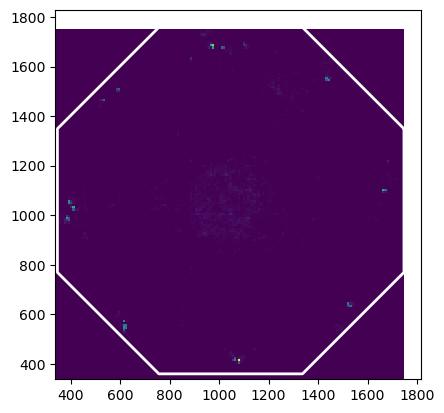

In [141]:
num_bins = 160

# Define spatial grid
x_edges = np.linspace(min(ind1_bodymiddle_x), max(ind1_bodymiddle_x), num_bins + 1)
y_edges = np.linspace(min(ind1_bodymiddle_y), max(ind1_bodymiddle_y), num_bins + 1)

# Get bin indices for each position
x_idx = np.digitize(ind1_bodymiddle_x, x_edges) - 1
y_idx = np.digitize(ind1_bodymiddle_y, y_edges) - 1

occupancy = np.zeros((num_bins, num_bins))

for t in range(len(ind1_bodymiddle_x)):
    xi, yi = x_idx[t], y_idx[t]
    if 0 <= xi < num_bins and 0 <= yi < num_bins:
        occupancy[xi, yi] += 1


plt.imshow(
    np.rot90(occupancy),
    extent=[min(ind1_bodymiddle_x), max(ind1_bodymiddle_x), min(ind1_bodymiddle_y), max(ind1_bodymiddle_y)],
    cmap='viridis',
    interpolation='nearest'
    )
plt.plot(np.append(oct_x, oct_x[0]), np.append(oct_y, oct_y[0]), 'w-', linewidth=2)

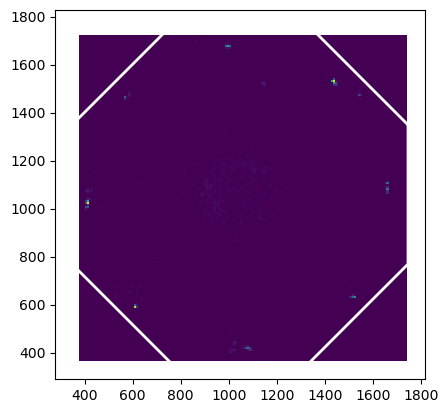

In [146]:
num_bins = 160

# Define spatial grid
x_edges = np.linspace(min(ind2_bodymiddle_x), max(ind2_bodymiddle_x), num_bins + 1)
y_edges = np.linspace(min(ind2_bodymiddle_y), max(ind2_bodymiddle_y), num_bins + 1)

# Get bin indices for each position
x_idx = np.digitize(ind2_bodymiddle_x, x_edges) - 1
y_idx = np.digitize(ind2_bodymiddle_y, y_edges) - 1

occupancy = np.zeros((num_bins, num_bins))

for t in range(len(ind2_bodymiddle_x)):
    xi, yi = x_idx[t], y_idx[t]
    if 0 <= xi < num_bins and 0 <= yi < num_bins:
        occupancy[xi, yi] += 1


plt.imshow(
    np.rot90(occupancy),
    extent=[min(ind2_bodymiddle_x), max(ind2_bodymiddle_x), min(ind2_bodymiddle_y), max(ind2_bodymiddle_y)],
    cmap='viridis',
    interpolation='nearest'
    )
plt.plot(np.append(oct_x, oct_x[0]), np.append(oct_y, oct_y[0]), 'w-', linewidth=2)

In [172]:
### Position tuning curve

import numpy as np

num_bins = 320
identity = 'other'

# Define spatial grid
x_edges = np.linspace(min(ind1_bodymiddle_x), max(ind1_bodymiddle_x), num_bins + 1)
y_edges = np.linspace(min(ind1_bodymiddle_y), max(ind1_bodymiddle_y), num_bins + 1)

# Get bin indices for each position
x_idx = np.digitize(ind1_bodymiddle_x, x_edges) - 1
y_idx = np.digitize(ind1_bodymiddle_y, y_edges) - 1

occupancy = np.zeros((num_bins, num_bins))
spike_maps = np.zeros((calcium_traces.shape[1], num_bins, num_bins))

for trial in range(39):
    # neural_data = calcium_traces[ms_trialStartStamps[trial]:ms_trialStartStamps[trial]+toneFrames[trial], :]
    for t in range(ms_trialStartStamps[trial+1] - ms_trialStartStamps[trial]):
        dlcFrame = dlc_trialStartStamps[trial] + t
        msFrame = ms_trialStartStamps[trial] + t
        if ind1_center_timestamps[dlcFrame] == 1:
            xi, yi = x_idx[dlcFrame], y_idx[dlcFrame]
            if 0 <= xi < num_bins and 0 <= yi < num_bins:
                occupancy[xi, yi] += 1
                spike_maps[:, xi, yi] += calcium_traces[msFrame]

epsilon = 1e-6
firing_rate_maps = spike_maps / (occupancy[None, :, :] + epsilon)

for neuron_id in range(calcium_traces.shape[1]):
    plt.imshow(
        np.rot90(firing_rate_maps[neuron_id]),
        extent=[min(ind1_bodymiddle_x), max(ind1_bodymiddle_x), min(ind1_bodymiddle_y), max(ind1_bodymiddle_y)],
        cmap='viridis',
        interpolation='nearest'
    )

    # Inradius (distance from center to flat wall)
    inradius = 700  # in cm or units that match your position data

    # Compute the circumradius
    circumradius = inradius / np.cos(np.pi / 8)

    # Octagon angles (8 points around a circle, offset to make a flat top)
    angles = np.linspace(0, 2 * np.pi, 9)[:-1] + np.pi / 8

    # Center of arena (adjust based on your data)
    cx, cy = plate_center

    # Compute vertex positions
    oct_x = cx + circumradius * np.cos(angles)
    oct_y = cy + circumradius * np.sin(angles)

    # Draw the octagon outline
    plt.plot(np.append(oct_x, oct_x[0]), np.append(oct_y, oct_y[0]), 'w-', linewidth=2)

    plt.title(f"Spatial tuning curve Neuron {neuron_id}")
    plt.xlabel("X position")
    plt.ylabel("Y position")
    plt.colorbar(label="Firing rate (events per frame)")
    fig_dir = f'/Users/fgs/HMLworkplace/Arena_analysis/Event_response/position_tuningcurve/{mouse}_{date}/other_selfInCenter'
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    plt.savefig(f"{fig_dir}/{neuron_id}.png", dpi=400)
    plt.close()


In [34]:
### Plot the neural activities around peer reward claiming
other_rewardTimes = get_state_time('Poke1Remain1', bpod_data, ind2_winTrials)
other_rewardFrames = np.rint(30*other_rewardTimes).astype(int)
FPS = 30
for k, single_neuron_C in enumerate(minian_results.C):
    time_range = np.linspace(-3,3,180)
    singleNeuronArounTone = {}
    other_ms_rewardFrames = ms_trialStartStamps[ind2_winTrials] + other_rewardFrames
    windowStarts = other_ms_rewardFrames - FPS*3
    windowEnds = other_ms_rewardFrames + FPS*3
    colors = plt.cm.viridis(np.linspace(0, 1, len(windowStarts)))
    calciumTraceAroundTone_list = []
    plt.figure(figsize=(15,10))
    for i, windowStart in enumerate(windowStarts):
        windowEnd = windowEnds[i]
        calciumTraceAroundTone = single_neuron_C[windowStart:windowEnd]
        calciumTraceAroundTone_list.append(calciumTraceAroundTone)
        plt.plot(time_range, calciumTraceAroundTone, color=colors[i], alpha=0.5)
    calciumTraceAroundTone_list = np.array(calciumTraceAroundTone_list)
    average_activity = np.mean(calciumTraceAroundTone_list, axis=0)
    plt.plot(time_range, average_activity, color='black', linewidth=2, label='Average')
    plt.xlabel('Time(s)', labelpad=20)
    plt.ylabel('Calcium Activity')
    plt.legend()
    plt.title(f'Neuron{k} activity around other claming rewad', fontsize=16, pad=10)
    save_path = f'/Users/fgs/HMLworkplace/Arena_analysis/Event_response/peer_reward_claiming/{mouse}/{date}/'
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    plt.savefig(f'{save_path}/{k}.png')
    plt.close()